### Move to front competitive analysis

#### Introduction to the Analysis of Algorithms (3rd ed)
##### Michael Soltys

##### Notebook by Ryan McIntyre

We'll start by depicting MTF:

In [1]:
def MTF(cache,request):
    L = [0 for i in range(cache_size)]
    i = 0
    found = False
    while i < len(L):
        if L[i] == request:
            L = [request] + L[:i] + L[i+1:]
            found = True
            break
        i += 1
    if not found:
        L = [request] + L[:-1]

Of course, for our purposes it would be nice to have an "offline" version to compare to the optimal offline solution; we define below the offline MTF, with utilities for tracking cost; we also add the non-crucial simplification discussed in problem 5.7: It is assumed that all requested items are already in the cache.

In [2]:
from copy import deepcopy as copy
            
def MTF_cost(initial_cache,requests):
    L = copy(initial_cache)
    cost = 0
    for r in requests:
        i = 0
        while i < len(L):
            if r == L[i]:
                cost += i+1
                L = [L[i]] + L[:i] + L[i+1:]
                break
            i += 1
    return cost

We need OPT... we'll make a brute-force method for finding OPT's cost using a uniform cost search, with the same simplification.
Note that we don't bother to track which moves result in the optimum cost, as we're only using the cost itself for comparison.

In [3]:
def OPT_cost(initial_cache,requests):
    cost = dict()
    requests = copy(requests)
    initial_cache = copy(initial_cache)
    k = len(initial_cache)
    
    cost[str((initial_cache,requests))] = 0
    expanded = set()
    frontier = [(initial_cache,requests)]
    while True:
        frontier.sort(key = lambda x : cost[str(x)], reverse=True)
        exp = frontier.pop()
        expanded.add(str(exp))
        if exp[1] == []:
            return cost[str(exp)]
        else:
            moves = [('transpose',i) for i in range(k-1)]
            i = exp[0].index(exp[1][0])
            moves += [('access',i,j) for j in range(i+1)]
            for move in moves:
                if move[0] == 'transpose':
                    ca = exp[0]
                    i = move[1]
                    ca = ca[:i] + [ca[i+1],ca[i]] + ca[i+2:]
                    new = (ca,exp[1])
                    if not str(new) in expanded:
                        if str(new) in cost:
                            if cost[str(exp)] + 1 < cost[str(new)]:
                                cost[str(new)] = cost[str(exp)] + 1
                        else:
                            cost[str(new)] = cost[str(exp)] + 1
                            frontier.append(new)
                elif move[0] =='access':
                    i = move[1]
                    j = move[2]
                    ca = exp[0]
                    ca = ca[:j] + [ca[i]] + ca[j:i] + ca[i+1:]
                    new = (ca,exp[1][1:])
                    if not str(new) in expanded:
                        if str(new) in cost:
                            if cost[str(exp)] + i+1 < cost[str(new)]:
                                cost[str(new)] = cost[str(exp)] + i+1
                        else:
                            cost[str(new)] = cost[str(exp)] + i+1
                            frontier.append(new)

Next we define a simple test case (for which MTF should be optimal):

In [4]:
in_cache = [1,2,3]
requests = [3,3,3,2,2,2,1]
print('OPT cost:',OPT_cost(in_cache,requests))
print('MTF cost:',MTF_cost(in_cache,requests))

OPT cost: 13
MTF cost: 13


Finally we're ready to run our experiment. For each cache size for which the brute-force solution runs quickly (which is an unsurprisingly small range) generate 100 sample request lists of length $2\times \text{cache_size}$ from a uniform distribution of elements in the starting cache. We then find the average $\frac{\text{cost}}{\text{request}}$ over all of the samples for OPT and MTF.

In [13]:
from random import randint
OPT_uniform = dict()
MTF_uniform = dict()
max_cache = 6
sample_size = 100
for k in range(2,max_cache+1):
    sample_length = 2*k
    in_cache = [i for i in range(k)]
    requests = [[randint(0,k-1) for j in range(sample_length)] for i in range(sample_size)]
    OPT_uniform[k] = round(sum([OPT_cost(in_cache,request) for request in requests])/(sample_length*sample_size),3)
    MTF_uniform[k] = round(sum([MTF_cost(in_cache,request) for request in requests])/(sample_length*sample_size),3) 

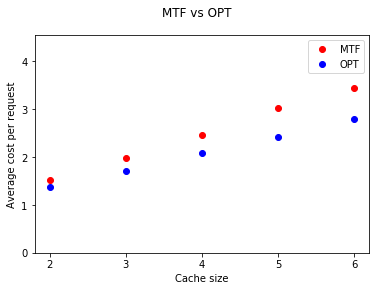

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
X = [i for i in range(2,max_cache+1)]
ax.plot(X,[MTF_uniform[x] for x in X],'ro',label='MTF')
ax.plot(X,[OPT_uniform[x] for x in X],'bo',label='OPT')
ax.set_ylim((0,ax.get_ylim()[1]+1))
ax.set_xticks(X)
ax.set_xlabel('Cache size')
ax.set_ylabel('Average cost per request')
fig.suptitle('MTF vs OPT')
ax.legend()
plt.show()

We see that, in the sample space we're able to explore, under a uniform distribution, MTF isn't far behind the optimal solution. Moreover, MTF should peform better on non-uniform distributions, as the "more frequent" pages will be more likely to be nearer the front of the cache.